In [1]:
# Load Libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import pybaseball as pyb
from pybaseball import statcast
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [2]:
# Import Data
df = pd.read_csv("/Users/genoc/Desktop/HyannisHarborHawks/Trackman/Cape_Trackman_Combined_July7.csv",low_memory=False)

# Clean Trackman Data
dft = df[['Pitcher', 'PitcherTeam', 'Batter', 'BatterTeam', 'PitcherThrows', 'RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak', 'PitchCall', 'PlayResult', 'TaggedHitType', 'KorBB']]

#Rename the columns to be more descriptive
dft.rename(columns={'BatterTeam':'Batter Team', 'PitcherTeam':'Pitcher Team', 'PitcherThrows':'P Side', 'RelSpeed':'Velocity', 'SpinRate':'Spin Rate', 'RelHeight':'Release Height', 'RelSide':'Release Side', 'Extension':'Extension', 'InducedVertBreak':'Induced Vertical Break', 'HorzBreak':'Horizontal Break', 'PitchCall':'Pitch Call', 'PlayResult':'Play Result', 'TaggedHitType':'Hit Type'}, inplace=True)

#Add the Pitch Type and Pitch Result to the new dataframe
dft.insert(1, 'Pitch Type', df['TaggedPitchType'])
dft.insert(2, 'Pitch Result', df['PitchCall'])

#Create a new column for the difference between the Induced Vertical Break and the Horizontal Break (Absolute Value)
dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()

#Add two new columns for Pitch Location
dft.insert(10, 'Pitch Height', df['PlateLocHeight'])
dft.insert(11, 'Pitch Side', df['PlateLocSide'])

#Edit Horizontal Break to be absolute value of horizontal break
dft['Horizontal Break'] = abs(dft['Horizontal Break'])

dft['Release Side'] = abs(dft['Release Side'])

# Edit the pitcher names so the first name is first and the last name is last
dft['Pitcher'] = dft['Pitcher'].str.split(' ', expand=True)[1] + ' ' + dft['Pitcher'].str.split(' ', expand=True)[0]

# Edit the batter names so the first name is first and the last name is last
dft['Batter'] = dft['Batter'].str.split(' ', expand=True)[1] + ' ' + dft['Batter'].str.split(' ', expand=True)[0]

# Remove the comma from the last name
dft = dft.replace(',', '', regex=True)

# Add Swings and Misses to dft
dft['Whiff'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" else 0)
dft['Swing'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" or x == "InPlay" else 0)

# Calculates total swings and total misses across all of dft
total_swings = dft['Swing'].sum()
total_misses = dft['Whiff'].sum()

def categorize_os(dfsw):
    # Replace 'slider' with 'sweeper' or 'gyro' based on horizontal break values
    dfsw.loc[(dfsw['Pitch Type'] == 'Slider') & (dfsw['Horizontal Break'] > 14), 'Pitch Type'] = 'Sweeper'
    dfsw.loc[dfsw['Pitch Type'] == 'Slider', 'Pitch Type'] = 'Gyro'
    
    
    return dfsw

# Call the function to categorize sliders in the dataframe
dft = categorize_os(dft)

# Create a new dataframe with only pitches that are Four-Seam FB from RHP
dfsw = dft[(dft['Pitch Type'] == 'Sweeper')]

# Handle NA values
dfsw.fillna(dfbr.mean(), inplace=True)

dfsw['Spin Rate^2'] = pow(dfsw['Spin Rate'], 2)
dfsw['Horizontal Break Pow'] = pow(dfsw['Horizontal Break'], 3) + pow(dfsw['Horizontal Break'], 2)
dfsw['Extension^2'] = pow(dfsw['Extension'], 2)
dfsw['Velocity^2'] = pow(dfsw['Velocity'], 2)
dfsw['Release Side^2'] = pow(dfsw['Release Side'], 2)

# Filter to only include swings
dfsw_swing = dfsw[(dfsw['Swing'] == 1)]

C:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-2-1084c38bcfc8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()
<ipython-input-2-1084c38bcfc8>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [3]:
dfsw.head()

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,Hit Type,KorBB,Differential Break,Whiff,Swing,Spin Rate^2,Horizontal Break Pow,Extension^2,Velocity^2,Release Side^2
4,Javyn Pimental,Sweeper,StrikeSwinging,BRE_WHI,Andrew Patrick,BOU_BRA,Left,78.75653,2090.877416,5.22169,...,Undefined,Strikeout,25.65049,1,1,4.371768e+06,4324.067948,26.173251,6202.591018,5.608466
33,Ryan Fischer,Sweeper,StrikeSwinging,BOU_BRA,Trevor Austin,BRE_WHI,Right,84.81446,2052.127575,5.01679,...,Undefined,Strikeout,16.90202,1,1,4.211228e+06,12776.365574,35.869199,7193.492625,3.496900
43,Ryan Fischer,Sweeper,BallCalled,BOU_BRA,Jaime Ferrer,BRE_WHI,Right,82.94482,1772.976120,5.06691,...,Undefined,Undefined,7.92843,0,0,3.143444e+06,6170.789104,36.201882,6879.843165,2.988646
84,Javyn Pimental,Sweeper,BallCalled,BRE_WHI,Garett Michel,BOU_BRA,Left,76.00708,1896.831832,5.27152,...,Undefined,Undefined,23.65702,0,0,3.597971e+06,3824.563616,25.325553,5777.076210,7.002374
150,tommy szcepanski,Sweeper,FoulBall,BRE_WHI,Andrew Patrick,BOU_BRA,Right,79.64802,2532.428728,6.18422,...,Undefined,Undefined,18.19646,0,0,6.413195e+06,6321.646505,26.245334,6343.807090,2.493652


In [4]:
dfbr.columns

Index(['Pitcher', 'Pitch Type', 'Pitch Result', 'Pitcher Team', 'Batter',
       'Batter Team', 'P Side', 'Velocity', 'Spin Rate', 'Release Height',
       'Pitch Height', 'Pitch Side', 'Release Side', 'Extension',
       'Induced Vertical Break', 'Horizontal Break', 'Pitch Call',
       'Play Result', 'Hit Type', 'KorBB', 'Differential Break', 'Whiff',
       'Swing', 'Spin Rate^2', 'Horizontal Break Pow', 'Extension^2',
       'Velocity^2', 'Release Side^2'],
      dtype='object')

In [5]:
# Linear regression Model

X = dfsw_swing[['Spin Rate^2', 'Horizontal Break Pow', 'Induced Vertical Break', 'Differential Break', 'Extension^2', 'Velocity^2', 'Release Height', 'Release Side^2']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfsw_swing['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression object
linear_model = LinearRegression()

# Train the linear regression model using the training data
linear_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the linear regression model
y_linear_pred = linear_model.predict(X_test_scaled)

# Evaluate the linear regression model's performance
linear_mse = mean_squared_error(y_test, y_linear_pred)
linear_r2 = r2_score(y_test, y_linear_pred)

print("Linear Regression Mean Squared Error:", linear_mse)
print("Linear Regression R-squared score:", linear_r2)

Linear Regression Mean Squared Error: 0.24856865942040557
Linear Regression R-squared score: -0.00019293909639372941


In [6]:
# Get the feature coefficients from the model
feature_importances = linear_model.coef_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)


                        importance
Horizontal Break Pow      0.032004
Velocity^2                0.031571
Spin Rate^2               0.023396
Induced Vertical Break    0.004702
Release Side^2           -0.004241
Release Height           -0.007098
Differential Break       -0.012791
Extension^2              -0.022895


In [7]:
# Random Forest Model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest regressor object
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model using the training data
random_forest_model.fit(X_train, y_train)

# Predict Stuff+ scores for the test set using the Random Forest model
y_rf_pred = random_forest_model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

Random Forest Mean Squared Error: 0.2600747252747253
Random Forest R-squared score: -0.04649115646258517


In [8]:
# Get feature importances from the model
feature_importances = random_forest_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                        importance
Horizontal Break Pow      0.151550
Spin Rate^2               0.142345
Extension^2               0.132684
Velocity^2                0.125722
Release Height            0.120877
Release Side^2            0.119843
Differential Break        0.104063
Induced Vertical Break    0.102915


In [9]:
# XG Boost Model

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the XGBoost regressor object
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the XGBoost model using the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the XGBoost model
y_xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate the XGBoost model's performance
xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_r2 = r2_score(y_test, y_xgb_pred)

print("XGBoost Mean Squared Error:", xgb_mse)
print("XGBoost R-squared score:", xgb_r2)

XGBoost Mean Squared Error: 0.27911723407291916
XGBoost R-squared score: -0.12311458472198433


In [10]:
# Get feature importances from the model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                        importance
Extension^2               0.161082
Horizontal Break Pow      0.130903
Release Side^2            0.127375
Velocity^2                0.124092
Release Height            0.122468
Differential Break        0.118741
Induced Vertical Break    0.107792
Spin Rate^2               0.107547


In [11]:
# SVR Model 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Support Vector Regression model
svr_model = SVR(kernel='linear')

# Train the model using the training data
svr_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the SVR model
y_pred = svr_model.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

Mean Squared Error: 0.37915368013169876
R-squared score: -0.5256421891013592


In [12]:
# Neural Networks Model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))  # Single output neuron for the Stuff+ score prediction

# Compile the model
nn_model.compile(optimizer='adam', loss='mse')

# Train the model using the training data
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Predict Stuff+ scores for the test set using the Neural Network model
y_pred = nn_model.predict(X_test_scaled).flatten()

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

3/3 [==============================] - 0s 6ms/step
Mean Squared Error: 0.27387092612037606
R-squared score: -0.10200444081770366


In [13]:
# Ensemble model

# Make predictions using all the models
linear_pred = linear_model.predict(X_test_scaled)
rf_pred = random_forest_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
svr_pred = svr_model.predict(X_test_scaled)
keras_nn_pred = nn_model.predict(X_test_scaled).flatten()

# Combine predictions using averaging
ensemble_predictions = (linear_pred + rf_pred + xgb_pred + svr_pred + keras_nn_pred) / 5.0

3/3 [==============================] - 0s 9ms/step


In [14]:
# Get feature importances from the RandomForestRegressor and XGBRegressor models
rf_feature_importances = random_forest_model.feature_importances_
xgb_feature_importances = xgb_model.feature_importances_

# Calculate average feature importances across the two models
average_feature_importances = (rf_feature_importances + xgb_feature_importances) / 2.0

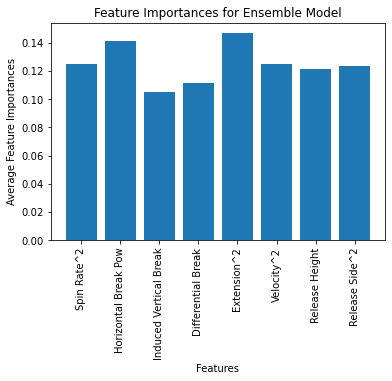

In [15]:
features_list = ['Spin Rate^2', 'Horizontal Break Pow', 'Induced Vertical Break', 'Differential Break', 'Extension^2', 'Velocity^2', 'Release Height', 'Release Side^2']

plt.bar(features_list, average_feature_importances)
plt.xlabel('Features')
plt.ylabel('Average Feature Importances')
plt.title('Feature Importances for Sweeper Ensemble Model')
plt.xticks(rotation=90)
plt.show()

In [16]:
X = dfsw[['Spin Rate^2', 'Horizontal Break Pow', 'Induced Vertical Break', 'Differential Break', 'Extension^2', 'Velocity^2', 'Release Height', 'Release Side^2']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfsw['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Make predictions on the training set using all the models
linear_pred_train = linear_model.predict(X_train_scaled)
rf_pred_train = random_forest_model.predict(X_train_scaled)
xgb_pred_train = xgb_model.predict(X_train_scaled)
svr_pred_train = svr_model.predict(X_train_scaled)
keras_nn_pred_train = nn_model.predict(X_train_scaled).flatten()

44/44 [==============================] - 0s 2ms/step


In [18]:
# Make predictions on the test set using all the models
linear_pred_test = linear_model.predict(X_test_scaled)
rf_pred_test = random_forest_model.predict(X_test_scaled)
xgb_pred_test = xgb_model.predict(X_test_scaled)
svr_pred_test = svr_model.predict(X_test_scaled)
keras_nn_pred_test = nn_model.predict(X_test_scaled).flatten()

11/11 [==============================] - 0s 2ms/step


In [19]:
# Combine predictions using averaging for the training set
ensemble_predictions_train = (linear_pred_train + rf_pred_train + xgb_pred_train + svr_pred_train + keras_nn_pred_train) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the training set
ensemble_df_train = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_train}, index=X_train.index)

In [20]:
# Combine predictions using averaging for the test set
ensemble_predictions_test = (linear_pred_test + rf_pred_test + xgb_pred_test + svr_pred_test + keras_nn_pred_test) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the test set
ensemble_df_test = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_test}, index=X_test.index)

In [21]:
# Concatenate the training and test set DataFrames
ensemble_df = pd.concat([ensemble_df_train, ensemble_df_test])

In [22]:
# Calculate the 'Stuff+' values
dfsw['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100

<ipython-input-22-b5695bafb0d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbr['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100


In [23]:
dfsw['Stuff+'].describe()

count    1760.000000
mean      100.000000
std        26.347655
min        27.767630
25%        80.318865
50%        97.952871
75%       118.684970
max       189.391038
Name: Stuff+, dtype: float64

In [24]:
dfsw.head(30)

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,KorBB,Differential Break,Whiff,Swing,Spin Rate^2,Horizontal Break Pow,Extension^2,Velocity^2,Release Side^2,Stuff+
4,Javyn Pimental,Sweeper,StrikeSwinging,BRE_WHI,Andrew Patrick,BOU_BRA,Left,78.75653,2090.877416,5.22169,...,Strikeout,25.65049,1,1,4.371768e+06,4324.067948,26.173251,6202.591018,5.608466,104.145854
33,Ryan Fischer,Sweeper,StrikeSwinging,BOU_BRA,Trevor Austin,BRE_WHI,Right,84.81446,2052.127575,5.01679,...,Strikeout,16.90202,1,1,4.211228e+06,12776.365574,35.869199,7193.492625,3.496900,133.641529
43,Ryan Fischer,Sweeper,BallCalled,BOU_BRA,Jaime Ferrer,BRE_WHI,Right,82.94482,1772.976120,5.06691,...,Undefined,7.92843,0,0,3.143444e+06,6170.789104,36.201882,6879.843165,2.988646,83.589706
84,Javyn Pimental,Sweeper,BallCalled,BRE_WHI,Garett Michel,BOU_BRA,Left,76.00708,1896.831832,5.27152,...,Undefined,23.65702,0,0,3.597971e+06,3824.563616,25.325553,5777.076210,7.002374,96.500341
150,tommy szcepanski,Sweeper,FoulBall,BRE_WHI,Andrew Patrick,BOU_BRA,Right,79.64802,2532.428728,6.18422,...,Undefined,18.19646,0,0,6.413195e+06,6321.646505,26.245334,6343.807090,2.493652,85.437623
153,tommy szcepanski,Sweeper,StrikeCalled,BRE_WHI,Andrew Patrick,BOU_BRA,Right,81.10106,2639.241297,6.12695,...,Strikeout,11.97548,0,0,6.965595e+06,3386.937292,27.316929,6577.381933,2.157814,91.870588
155,tommy szcepanski,Sweeper,BallCalled,BRE_WHI,Josh Kuroda-Grauer,BOU_BRA,Right,81.29376,2560.823926,6.08667,...,Undefined,12.68678,0,0,6.557819e+06,4032.532946,24.247647,6608.675415,2.377240,90.300237
165,tommy szcepanski,Sweeper,StrikeCalled,BRE_WHI,Jackson Castillo,BOU_BRA,Right,81.39244,2622.073381,6.14262,...,Undefined,19.96336,0,0,6.875269e+06,4030.890769,25.904130,6624.729289,2.412430,104.045462
199,jacob exum,Sweeper,FoulBall,BOU_BRA,Jaime Ferrer,BRE_WHI,Right,84.13747,2306.824536,3.87135,...,Undefined,17.47359,0,0,5.321439e+06,11308.510110,39.228301,7079.113858,16.949936,124.108285
208,jacob exum,Sweeper,FoulBall,BOU_BRA,Joe Stella,BRE_WHI,Right,76.07981,2190.358256,4.13496,...,Undefined,21.84934,0,0,4.797669e+06,3701.816036,30.436296,5788.137490,19.778210,111.104483


In [29]:
# Sort the DataFrame by 'Stuff+' values in descending order
dfsw_sorted = dfsw.sort_values(by='Stuff+', ascending=False)

# Reset the index of the sorted DataFrame
dfsw_sorted.reset_index(drop=True, inplace=True)

dfsw_sorted.head(20)

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,KorBB,Differential Break,Whiff,Swing,Spin Rate^2,Horizontal Break Pow,Extension^2,Velocity^2,Release Side^2,Stuff+
0,Brendan Lysik,Sweeper,BallinDirt,BRE_WHI,Matt Scannell,HAR_MAR,Left,74.92680,1755.842636,8.50531,...,Undefined,16.60698,0,0,3.082983e+06,5246.228665,26.254351,5614.025358,11.498881,189.391038
1,Brendan Lysik,Sweeper,StrikeCalled,BRE_WHI,Seaver King,HAR_MAR,Left,72.29573,1858.459113,8.41974,...,Undefined,11.73816,0,0,3.453870e+06,5979.657461,26.524148,5226.672576,10.091995,187.071488
2,Brendan Lysik,Sweeper,BallCalled,BRE_WHI,Devin Obee,HAR_MAR,Left,78.90824,1625.459380,8.30951,...,Undefined,21.52387,0,0,2.642118e+06,8264.790625,29.014813,6226.510340,8.804276,186.597469
3,Griffin Stieg,Sweeper,BallCalled,BOU_BRA,Cameron Smith,HYA_HAR,Right,95.27411,2436.537016,4.26960,...,Undefined,17.95588,0,0,5.936713e+06,13442.741014,29.185061,9077.156036,3.565261,171.403441
4,Cade Obermueller,Sweeper,BallCalled,HYA_HAR,Matthew Etzel,CHA_ANG,Left,81.27839,2825.056242,4.21845,...,Undefined,6.20784,0,0,7.980943e+06,3388.460577,33.270632,6606.176681,8.395796,167.816135
5,Cam Schuelke,Sweeper,StrikeCalled,COT_KET,Jack Goodman,YAR_RED,Right,73.96464,2808.598406,4.92123,...,Undefined,9.76898,0,0,7.888225e+06,10961.673728,20.720431,5470.767970,5.665352,167.436874
6,Xavier Martinez,Sweeper,BallCalled,HAR_MAR,Hudson White,CHA_ANG,Right,74.51257,2884.201414,5.56152,...,Undefined,14.08627,0,0,8.318618e+06,12611.858411,24.759382,5552.123088,2.275391,167.101778
7,Brendan Lysik,Sweeper,StrikeCalled,BRE_WHI,Ali Camarillo,HAR_MAR,Left,73.05733,1895.985978,5.21446,...,Undefined,20.37028,0,0,3.594763e+06,10872.143431,33.897314,5337.373467,12.762185,165.264413
8,Xavier Martinez,Sweeper,FoulBall,HAR_MAR,Fenwick Trimble,ORL_FIR,Right,75.31993,2809.318265,5.29241,...,Undefined,11.13894,0,0,7.892269e+06,10958.816217,25.019104,5673.091855,2.647877,164.746915
9,Daniel Avitia,Sweeper,BallCalled,ORL_FIR,Brody Donay,HYA_HAR,Right,84.33066,1769.646946,4.56445,...,Undefined,22.22021,0,0,3.131650e+06,11465.471933,31.241616,7111.660216,2.765569,164.502829


In [31]:
average_sw_Stuff = dfsw[dfsw['Pitch Type'] == 'Sweeper'].groupby('Pitcher')['Stuff+'].mean()
average_sw_Stuff = average_sw_Stuff.round(2)

# Sort the Series in descending order based on the average Stuff+ values
average_sw_Stuff_sorted = average_sw_Stuff.sort_values(ascending=False)

average_sw_Stuff_sorted

Pitcher
Cole Roland              161.66
Antoine Jean             155.89
Sean Hard                146.87
Paulshawn Pasqualotto    146.68
Brendan Lysik            144.41
                          ...  
Izaak Martinez            53.68
Carson Dorsey             51.83
Jr. Tejada                48.92
Liam Doyle                46.72
Zander Sechrist           43.14
Name: Stuff+, Length: 172, dtype: float64